In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys
print(sys.version)
%matplotlib inline

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Please specify the test image name here
test_image = "image6.jpg" 

In [3]:
test_image_folder = "../data/"
path_to_test_image = test_image_folder + test_image


LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height


BOX               = int(len(ANCHORS)/2)
TRUE_BOX_BUFFER   = 50
IMAGE_H, IMAGE_W  = 416, 416
GRID_H,  GRID_W   = 13 , 13

In [4]:
# Load the model architecture and its trained weights
from model_architechture import YOLOv2_architecture

CLASS             = len(LABELS)
model, _          = YOLOv2_architecture(IMAGE_H,IMAGE_W,GRID_H,GRID_W,TRUE_BOX_BUFFER,BOX,CLASS, 
                                  trainable=False)
model.load_weights("./yolo_v2/weights_yolo_on_voc2012.h5")

In [5]:
# Encode the image using the ImageReader class
from backend import ImageReader
imageReader = ImageReader(IMAGE_H,IMAGE_W=IMAGE_W, norm=lambda image : image / 255.)
out = imageReader.fit(path_to_test_image)

In [6]:
# Predict the bounding box.
print(out.shape)
X_test = np.expand_dims(out,0)
print(X_test.shape)
# handle the hack input
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
y_pred = model.predict([X_test,dummy_array])
print(y_pred.shape)

(416, 416, 3)
(1, 416, 416, 3)
(1, 13, 13, 4, 25)


In [7]:
# Rescale the network output
# Remind you that y_pred takes any real values. Therefore
class OutputRescaler(object):
    def __init__(self,ANCHORS):
        self.ANCHORS = ANCHORS

    def _sigmoid(self, x):
        return 1. / (1. + np.exp(-x))
    def _softmax(self, x, axis=-1, t=-100.):
        x = x - np.max(x)

        if np.min(x) < t:
            x = x/np.min(x)*t

        e_x = np.exp(x)
        return e_x / e_x.sum(axis, keepdims=True)
    def get_shifting_matrix(self,netout):
        
        GRID_H, GRID_W, BOX = netout.shape[:3]
        no = netout[...,0]
        
        ANCHORSw = self.ANCHORS[::2]
        ANCHORSh = self.ANCHORS[1::2]
       
        mat_GRID_W = np.zeros_like(no)
        for igrid_w in range(GRID_W):
            mat_GRID_W[:,igrid_w,:] = igrid_w

        mat_GRID_H = np.zeros_like(no)
        for igrid_h in range(GRID_H):
            mat_GRID_H[igrid_h,:,:] = igrid_h

        mat_ANCHOR_W = np.zeros_like(no)
        for ianchor in range(BOX):    
            mat_ANCHOR_W[:,:,ianchor] = ANCHORSw[ianchor]

        mat_ANCHOR_H = np.zeros_like(no) 
        for ianchor in range(BOX):    
            mat_ANCHOR_H[:,:,ianchor] = ANCHORSh[ianchor]
        return(mat_GRID_W,mat_GRID_H,mat_ANCHOR_W,mat_ANCHOR_H)

    def fit(self, netout):    
        '''
        netout  : np.array of shape (N grid h, N grid w, N anchor, 4 + 1 + N class)
        
        a single image output of model.predict()
        '''
        GRID_H, GRID_W, BOX = netout.shape[:3]
        
        (mat_GRID_W,
         mat_GRID_H,
         mat_ANCHOR_W,
         mat_ANCHOR_H) = self.get_shifting_matrix(netout)


        # bounding box parameters
        netout[..., 0]   = (self._sigmoid(netout[..., 0]) + mat_GRID_W)/GRID_W # x      unit: range between 0 and 1
        netout[..., 1]   = (self._sigmoid(netout[..., 1]) + mat_GRID_H)/GRID_H # y      unit: range between 0 and 1
        netout[..., 2]   = (np.exp(netout[..., 2]) * mat_ANCHOR_W)/GRID_W      # width  unit: range between 0 and 1
        netout[..., 3]   = (np.exp(netout[..., 3]) * mat_ANCHOR_H)/GRID_H      # height unit: range between 0 and 1
        # rescale the confidence to range 0 and 1 
        netout[..., 4]   = self._sigmoid(netout[..., 4])
        expand_conf      = np.expand_dims(netout[...,4],-1) # (N grid h , N grid w, N anchor , 1)
        # rescale the class probability to range between 0 and 1
        # Pr(object class = k) = Pr(object exists) * Pr(object class = k |object exists)
        #                      = Conf * P^c
        netout[..., 5:]  = expand_conf * self._softmax(netout[..., 5:])
        # ignore the class probability if it is less than obj_threshold 
    
        return(netout)

In [8]:
# Experiment OutputRescaler
netout         = y_pred[0]
outputRescaler = OutputRescaler(ANCHORS=ANCHORS)
netout_scale   = outputRescaler.fit(netout)

In [9]:
# YOLOv2 can potentially preoduce GRID_H x GRID_W x BOX many bounding box. However, 
# only few of them actually contain actual objects. 
# Some bounding box may contain the same objects. I will postprocess the predicted bounding box.
from backend import BoundBox

    
def find_high_class_probability_bbox(netout_scale, obj_threshold):
    '''
    == Input == 
    netout : y_pred[i] np.array of shape (GRID_H, GRID_W, BOX, 4 + 1 + N class)
    
             x, w must be a unit of image width
             y, h must be a unit of image height
             c must be in between 0 and 1
             p^c must be in between 0 and 1
    == Output ==
    
    boxes  : list containing bounding box with Pr(object is in class C) > 0 for at least in one class C 
    
             
    '''
    GRID_H, GRID_W, BOX = netout_scale.shape[:3]
    
    boxes = []
    for row in range(GRID_H):
        for col in range(GRID_W):
            for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout_scale[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout_scale[row,col,b,:4]
                    confidence = netout_scale[row,col,b,4]
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    if box.get_score() > obj_threshold:
                        boxes.append(box)
    return(boxes)   

In [10]:
obj_threshold = 0.015
boxes_tiny_threshold = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("obj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes_tiny_threshold),obj_threshold))

obj_threshold = 0.03
boxes = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("\nobj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes),obj_threshold))

obj_threshold=0.015
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 30 bounding boxes with top class probability > 0.015

obj_threshold=0.03
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 20 bounding boxes with top class probability > 0.03


In [11]:
# Most of the bounding boxes do not contain objects. This shows that we really need to reduce the number of bounding box.
import cv2, copy
import seaborn as sns
def draw_boxes(image, boxes, labels, obj_baseline=0.05,verbose=False):
    '''
    image : np.array of shape (N height, N width, 3)
    '''
    def adjust_minmax(c,_max):
        if c < 0:
            c = 0   
        if c > _max:
            c = _max
        return c
    
    image = copy.deepcopy(image)
    image_h, image_w, _ = image.shape
    score_rescaled  = np.array([box.get_score() for box in boxes])
    score_rescaled /= obj_baseline
    
    colors = sns.color_palette("husl", len(boxes))
    for sr, box,color in zip(score_rescaled,boxes, colors):
        xmin = adjust_minmax(int(box.xmin*image_w),image_w)
        ymin = adjust_minmax(int(box.ymin*image_h),image_h)
        xmax = adjust_minmax(int(box.xmax*image_w),image_w)
        ymax = adjust_minmax(int(box.ymax*image_h),image_h)
        
        text = "{} {:4.3f}".format(labels[box.label], box.get_score())
        if verbose:
            print("{} xmin={:4.0f},ymin={:4.0f},xmax={:4.0f},ymax={:4.0f}".format(text,xmin,ymin,xmax,ymax,text))
        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), color, 2)
        cv2.putText(img       = image, 
                    text      = text, 
                    org       = (xmin+13, ymin+13),
                    fontFace  = cv2.FONT_HERSHEY_TRIPLEX,
                    fontScale = 12e-4 * image_h,
                    color     = (1, 0, 0),
                    thickness = 1,
                    lineType = cv2.LINE_AA)
        
    return image

In [12]:
# Nonmax surpression is a way to detect a single object only once.
# The following code implement the nonmax surpression algorithm. 
# For each object class, the algorithm picks the most promissing bounding box, 
# and then remove (or suppress) the remaining bounding box that contain high overwrap with the most promissing bounding box.
#The most promissing or not is determined by the predicted class probaiblity.
from backend import BestAnchorBoxFinder
def nonmax_suppression(boxes,iou_threshold,obj_threshold):
    '''
    boxes : list containing "good" BoundBox of a frame
            [BoundBox(),BoundBox(),...]
    '''
    bestAnchorBoxFinder    = BestAnchorBoxFinder([])
    
    CLASS    = len(boxes[0].classes)
    index_boxes = []   
    # suppress non-maximal boxes
    for c in range(CLASS):
        # extract class probabilities of the c^th class from multiple bbox
        class_probability_from_bbxs = [box.classes[c] for box in boxes]

        #sorted_indices[i] contains the i^th largest class probabilities
        sorted_indices = list(reversed(np.argsort( class_probability_from_bbxs)))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            # if class probability is zero then ignore
            if boxes[index_i].classes[c] == 0:  
                continue
            else:
                index_boxes.append(index_i)
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    # check if the selected i^th bounding box has high IOU with any of the remaining bbox
                    # if so, the remaining bbox' class probabilities are set to 0.
                    bbox_iou = bestAnchorBoxFinder.bbox_iou(boxes[index_i], boxes[index_j])
                    if bbox_iou >= iou_threshold:
                        classes = boxes[index_j].classes
                        classes[c] = 0
                        boxes[index_j].set_class(classes)
                        
    newboxes = [ boxes[i] for i in index_boxes if boxes[i].get_score() > obj_threshold ]                
    
    return newboxes

In [13]:
iou_threshold = 0.01
final_boxes = nonmax_suppression(boxes,iou_threshold=iou_threshold,obj_threshold=0.07)

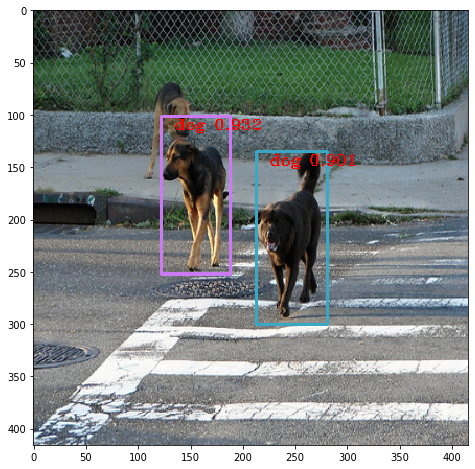

In [14]:
ima = draw_boxes(X_test[0],final_boxes,LABELS,verbose=False)
figsize = (10,8)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.show()